In [22]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Build a data pipeline

In [23]:
def extract():

    local_zip = r"C:\Users\karat\OneDrive\Documents\machine learning\datasets\air_pass_time_series.zip"
    extract_dir = r"C:\Users\karat\OneDrive\Documents\machine learning\datasets\air_pass_time_series"

    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    return os.path.join(extract_dir, "AirPassengers.csv")

def load_data(df,path):
    df = pd.read_csv(path)
    return df

def set_index(data):
    data['Month'] = pd.to_datetime(data['Month'])
    data.set_index('Month', inplace=True)

    return data

def rename(data, columns):
    data.rename(columns=columns, inplace=True)
    return data

def viz_data(data):
    colors = sns.color_palette()
    data.plot(style='-', figsize=(15,5), color=colors[0], title='Air Passengers')
    plt.show()

    return data

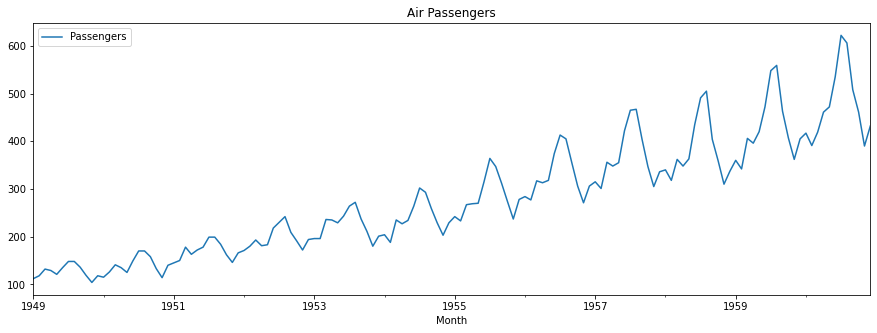

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


In [24]:
path = extract()

df = (pd.DataFrame()
        .pipe(lambda df: load_data(df, path))
        .pipe(set_index)
        .pipe(lambda df: rename(df,columns={'#Passengers': 'Passengers'}))
        .pipe(viz_data))
    
print(df.head())

Some utility functions

In [25]:
#%conda install xgboost

In [26]:
import xgboost as xgb

def data_split(df):

    train_size = int(len(df) * 0.70)
    train, test = df[0:train_size], df[train_size:]
    return train, test

def viz_train_test(train,test):

    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
    test.plot(ax=ax, label='Test Set')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()

def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df

def create_model(estimators,learning_rate,max_depth,stop_rounds): 

    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=estimators,
                       early_stopping_rounds=stop_rounds,
                       objective='reg:linear',
                       max_depth=max_depth,
                       learning_rate=learning_rate)
    
    return model

def viz_feature_imp(model):

    plt.figure(figsize=(20, 16))
    xgb.plot_importance(model, importance_type='weight', title='Feature Importance', xlabel='F Score', ylabel='Features')
    plt.show()

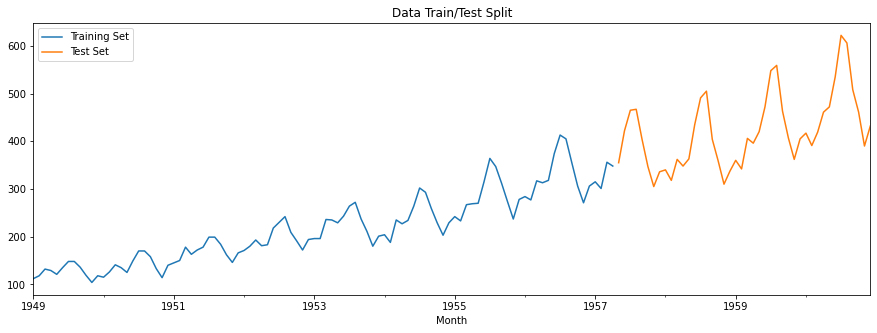

In [27]:
train,test = data_split(df)
viz_train_test(train,test)

In [28]:
train = create_features(train)
test = create_features(test)

In [29]:
train = train.reset_index(drop=True)
train = train.apply(pd.to_numeric, errors='coerce')

test = test.reset_index(drop=True)
test = test.apply(pd.to_numeric, errors='coerce')

x_train = train.drop('Passengers', axis=1)
y_train = train['Passengers']

test = test.reset_index(drop=True)
x_test = test.drop('Passengers', axis=1)
y_test = test['Passengers']

x_train['weekofyear'] = x_train['weekofyear'].astype(int)
x_test['weekofyear'] = x_test['weekofyear'].astype(int)

In [30]:
x_train.dtypes

hour          int64
dayofweek     int64
quarter       int64
month         int64
year          int64
dayofyear     int64
dayofmonth    int64
weekofyear    int32
dtype: object

In [31]:
model = create_model(estimators=1000,learning_rate=0.01,max_depth=3,stop_rounds=100)

model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

[14:41:36] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:36] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:227.86526	validation_1-rmse:424.52417
[100]	validation_0-rmse:91.03744	validation_1-rmse:238.14244
[200]	validation_0-rmse:39.95060	validation_1-rmse:161.85863
[300]	validation_0-rmse:19.96621	validation_1-rmse:128.12035
[400]	validation_0-rmse:11.73710	validation_1-rmse:112.19331
[500]	validation_0-rmse:8.24154	validation_1-rmse:104.04546
[600]	validation_0-rmse:6.48853	validation_1-rmse:100.47112
[700]	validation_0-rmse:5.48190	validation_1-rmse:98.66848
[800]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=100,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<Figure size 1440x1152 with 0 Axes>

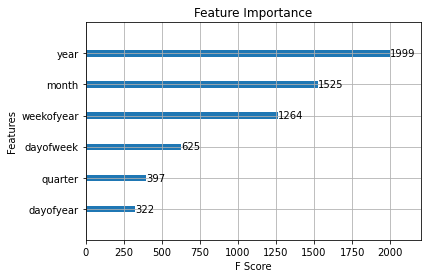

In [32]:
viz_feature_imp(model)

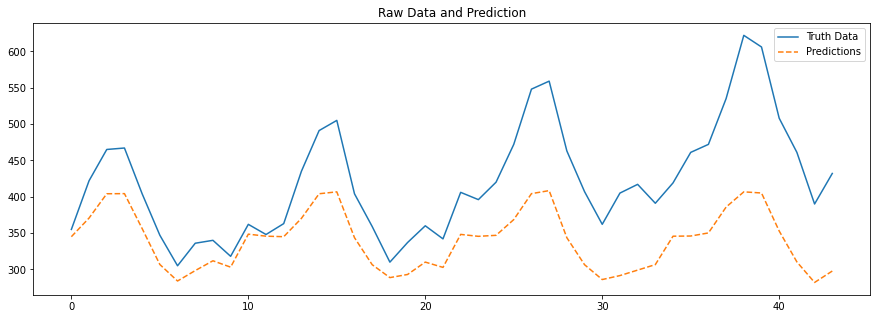

In [41]:
test['prediction'] = model.predict(x_test)
ax = test[['Passengers']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [43]:
score = np.sqrt(mean_squared_error(test['Passengers'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 95.37
